# Python Project - Portfolio Theory

This Notebook analyzes chosen stocks regarding the portfolio theory. The efficient frontier is calculated using two different approaches and afterwards evaluates the performance of selected portfolios.

First, the needed packages are loaded and installed. Then, the data is retrieved from Yahoo Finance. As the next step, the efficient frontier is calculated using the different approaches. Finally, the performance of two selected portfolios is evaluated.

In [3]:
# Load necessary packages
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr 
# package for dates
import datetime as dt

# Import packages for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Import the optimise sublibrary
import scipy.optimize as sco
import scipy.interpolate as sci

In [4]:
# The riskfree rate for this project is set equal to zero for simplicity:
rf=0.0

# Create a stock list of which the data is retrieved
stocks=['BA','IBM','NKE','AAPL','DIS','PFE','JNJ','MCD','XOM','JPM','AXP','UNH','PG','GE','KO','CVX','CSCO','CAT','MSFT','MRK','WMT','VZ']

# Set the timeframe starting in the beginning of 2018, ending in the end of November 2020
dates=pd.date_range(start="2018-01-01",end="2020-11-30")

# Retrieve data from Yahoo Finance ("finance.yahoo.com") - Adjusted Close Prices for the selected stocks
df=pdr.get_data_yahoo(stocks, start=dates[0], end=dates[-1])['Adj Close']
df.head()

Symbols,BA,IBM,NKE,AAPL,DIS,PFE,JNJ,MCD,XOM,JPM,AXP,UNH,PG,GE,KO,CVX,CSCO,CAT,MSFT,MRK,WMT,VZ
Date,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,282.886383,133.803574,61.536419,41.105534,108.726067,30.922344,128.347687,160.944946,72.152405,98.750923,94.424980,211.113892,83.115784,16.675669,41.253933,111.714676,35.458939,145.002594,82.383636,51.873783,93.182022,46.974339
2018-01-03,283.801239,137.481537,61.526726,41.098373,109.192856,31.151463,129.573715,160.266663,73.569473,98.851555,95.007141,213.328491,83.014915,16.833340,41.163342,112.529007,35.741806,145.224197,82.767044,51.799969,93.994858,46.009060
2018-01-04,282.724396,140.266037,61.487953,41.289268,109.144241,31.219345,129.564484,161.390915,73.671303,100.267670,96.587410,214.254440,83.601715,17.185772,41.743107,112.178757,35.842930,147.218613,83.495522,52.639614,94.079918,46.158237
2018-01-05,294.322296,140.951324,62.011341,41.759361,108.551003,31.278748,130.633850,161.716095,73.611900,99.623993,96.807686,218.339996,83.656731,17.195045,41.734043,111.994865,36.339340,149.545471,84.530701,52.584251,94.637550,46.052937
2018-01-08,295.570740,141.801422,62.563805,41.604263,106.994995,30.930826,130.799789,161.604584,73.942833,99.771095,95.916985,214.550339,84.096848,16.953909,41.670639,112.546539,36.716248,153.303497,84.616966,52.279762,96.036369,45.973961


In [5]:
# Look if there are values missing
print(df.isnull().sum())

# Drop the stock if more than 5 prices are missing, otherwise replace the missing values with the values in the previous row
df=df.dropna(axis=1,thresh=5)
stocks=df.columns
df=df.fillna(axis=1, method='ffill')
print(df.isnull().sum())

Symbols
BA      0
IBM     0
NKE     0
AAPL    0
DIS     0
PFE     0
JNJ     0
MCD     0
XOM     0
JPM     0
AXP     0
UNH     0
PG      0
GE      0
KO      0
CVX     0
CSCO    0
CAT     0
MSFT    0
MRK     0
WMT     0
VZ      0
dtype: int64
Symbols
BA      0
IBM     0
NKE     0
AAPL    0
DIS     0
PFE     0
JNJ     0
MCD     0
XOM     0
JPM     0
AXP     0
UNH     0
PG      0
GE      0
KO      0
CVX     0
CSCO    0
CAT     0
MSFT    0
MRK     0
WMT     0
VZ      0
dtype: int64


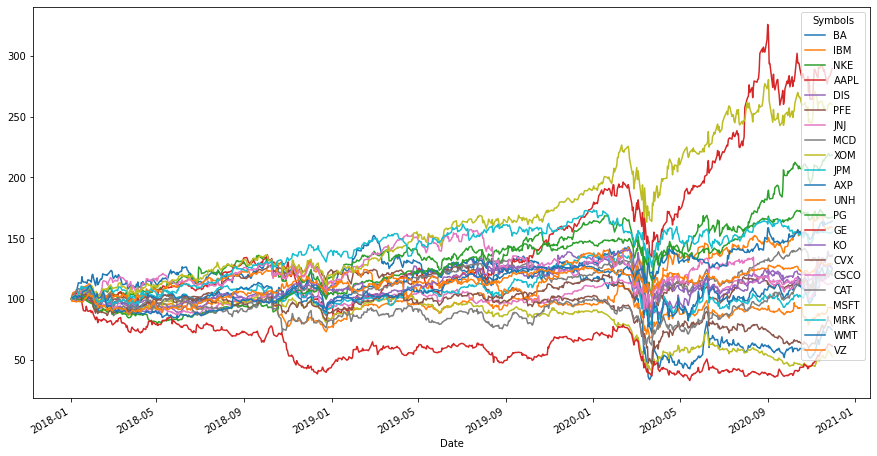

In [6]:
# Plot the 'Adj Close' value
# Normalize prices first so that they start at value 100
norm=df/df.iloc[0]*100
norm.plot(kind='line', y=stocks, figsize=(15,8))
plt.show()

In [7]:
# Calculate log returns
ret=np.log(df/df.shift(1))
# Drop missing values
ret=ret.dropna()

Text(0.5, 1.0, 'BA´s returns histogram')

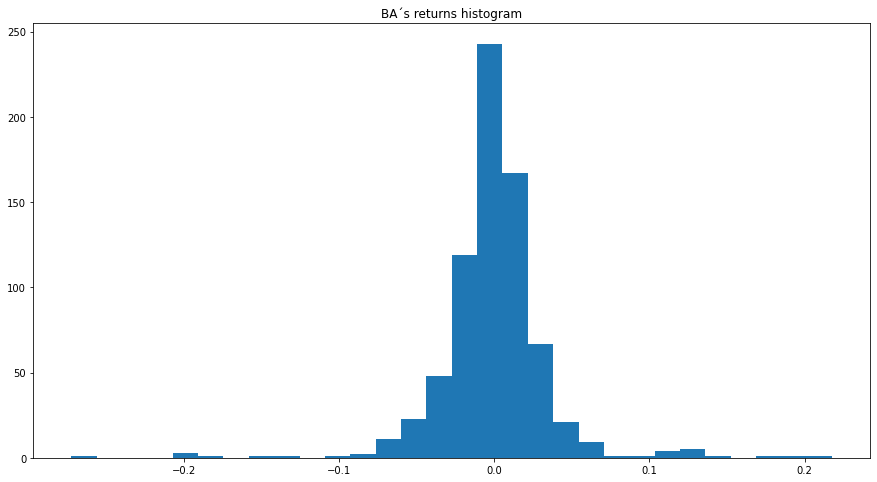

In [8]:
# Plot a histogram of the first stock´s returns
plt.figure(figsize=(15, 8))
plt.hist(ret[stocks[0]],bins=30)
plt.title('%s´s returns histogram' %stocks[0])

In [9]:
# Calculate annualized mean returns
avg_ret=ret.mean()*252

# Calculate a covariance matrix and variance
cov_mat=ret.cov()*252
var=ret.var()*252


# Calculate the efficient frontier:

## 1. Way - Closed End Solution:
#### Step 1: Calculate weight vectors for the minimum variance portfolio and the market portfolio
#### Step 2: Calculate different linear combinations of those portfolios
#### Step 3: Calculate returns and standard deviations of those portfolios
#### Step 4: Plot the risk-return combinations of the different portfolios

In [10]:
# Step 1:

# Calculate the minimum variance portfolio
# Step 1: create an Nx1 vector of 1s - N is the number of stocks
ones=np.arange(len(stocks))
ones=ones.reshape(len(stocks),1)
ones[:,0]=1

# Step 2: calculate a weight vector for the minimum variance portfolio
# First create a function to calculate the portfolio weights
def port_weights(covmat,returns):
  weights_port=np.matmul(np.linalg.inv(covmat),(returns-rf))/(np.matmul(np.matmul(np.matrix.transpose(ones),np.linalg.inv(cov_mat)),(returns-rf)))
  return(weights_port)

# Use function to calculate minimum variance portfolio weights, use ones-vector as return and a risk-free rate of 0%
w_mvp=port_weights(cov_mat,ones)
w_mvp=np.matrix.transpose(w_mvp)

# Calculate a weight vector for the market portfolio assuming a risk-free rate of 0% using the defined function
w_mkp=port_weights(cov_mat, avg_ret)
w_mkp=np.matrix.transpose(w_mkp)

# Combine the two weight vectors to an array
w_com=np.insert(w_mvp,[1],w_mkp,axis=0)

In [11]:
# Show weights of the minimum variance portfolio (MVP) and the market portfolio (MKP) in a dataframe
df_weights=pd.DataFrame(data=(w_com), index=['MVP','MKP'], columns=stocks)
df_weights

Symbols,BA,IBM,NKE,AAPL,DIS,PFE,JNJ,MCD,XOM,JPM,AXP,UNH,PG,GE,KO,CVX,CSCO,CAT,MSFT,MRK,WMT,VZ
MVP,-0.053948,-0.012532,0.055233,0.046687,0.095924,0.095528,0.121972,0.167323,0.097243,-0.015476,-0.105813,-0.043879,0.002322,0.014913,0.090967,-0.057268,-0.064570,0.014856,-0.082848,0.108274,0.187970,0.337122
MKP,-0.238674,-0.851550,1.078743,0.837738,0.288683,0.002328,-1.082732,-0.312550,-1.723187,0.244914,0.361941,-0.066631,0.714185,-0.257067,0.014468,0.315922,-0.689547,0.297977,0.652706,0.702378,0.246782,0.463174


#### Step 2:

In [12]:
# Step 2:
# Calculate different combinations of the two portfolios

# Step 1: create an array of weights for the two portfolios
lincom=np.arange(-1,2.1,0.1,dtype=float)
lincom=lincom.reshape(len(lincom),1)
lincom_flip=np.flip(lincom,0)
lincom=np.insert(lincom,[1],lincom_flip,axis=1)

# Step 2: calculate weights in the stocks for the different portfolio combinations
w_port=np.matmul(lincom,w_com)

# Step 3: print weigths in a dataframe
df_weights=pd.DataFrame(data=(w_port), columns=stocks)
df_weights

Symbols,BA,IBM,NKE,AAPL,DIS,PFE,JNJ,MCD,XOM,JPM,AXP,UNH,PG,GE,KO,CVX,CSCO,CAT,MSFT,MRK,WMT,VZ
0,-0.423400,-1.690569,2.102252,1.628790,0.481442,-0.090871,-2.287435,-0.792422,-3.543616,0.505303,0.829694,-0.089382,1.426047,-0.529047,-0.062032,0.689111,-1.314525,0.581098,1.388261,1.296482,0.305594,0.589226
1,-0.404928,-1.606667,1.999901,1.549685,0.462166,-0.081551,-2.166965,-0.744435,-3.361573,0.479265,0.782919,-0.087107,1.354861,-0.501849,-0.054382,0.651792,-1.252027,0.552786,1.314705,1.237072,0.299713,0.576620
2,-0.386455,-1.522765,1.897550,1.470579,0.442890,-0.072231,-2.046494,-0.696448,-3.179530,0.453226,0.736143,-0.084832,1.283675,-0.474651,-0.046732,0.614473,-1.189529,0.524474,1.241150,1.177661,0.293832,0.564015
3,-0.367982,-1.438863,1.795199,1.391474,0.423614,-0.062911,-1.926024,-0.648461,-2.997487,0.427187,0.689368,-0.082557,1.212488,-0.447453,-0.039082,0.577154,-1.127032,0.496161,1.167594,1.118251,0.287950,0.551410
4,-0.349510,-1.354961,1.692848,1.312369,0.404338,-0.053591,-1.805554,-0.600473,-2.815444,0.401148,0.642593,-0.080282,1.141302,-0.420255,-0.031432,0.539835,-1.064534,0.467849,1.094039,1.058841,0.282069,0.538805
5,-0.331037,-1.271059,1.590497,1.233264,0.385062,-0.044271,-1.685083,-0.552486,-2.633401,0.375109,0.595817,-0.078007,1.070116,-0.393057,-0.023782,0.502516,-1.002036,0.439537,1.020483,0.999430,0.276188,0.526200
6,-0.312565,-1.187158,1.488146,1.154159,0.365786,-0.034951,-1.564613,-0.504499,-2.451358,0.349070,0.549042,-0.075731,0.998930,-0.365859,-0.016132,0.465197,-0.939538,0.411225,0.946928,0.940020,0.270307,0.513594
7,-0.294092,-1.103256,1.385796,1.075054,0.346510,-0.025631,-1.444143,-0.456512,-2.269315,0.323031,0.502267,-0.073456,0.927743,-0.338661,-0.008482,0.427878,-0.877041,0.382913,0.873373,0.880609,0.264426,0.500989
8,-0.275620,-1.019354,1.283445,0.995949,0.327234,-0.016311,-1.323672,-0.408524,-2.087272,0.296992,0.455491,-0.071181,0.856557,-0.311463,-0.000832,0.390559,-0.814543,0.354601,0.799817,0.821199,0.258544,0.488384
9,-0.257147,-0.935452,1.181094,0.916844,0.307959,-0.006991,-1.203202,-0.360537,-1.905229,0.270953,0.408716,-0.068906,0.785371,-0.284265,0.006818,0.353241,-0.752045,0.326289,0.726262,0.761789,0.252663,0.475779


#### Step 3:

In [13]:
# Step 3:
# Calculate mean returns and standard deviations of those portfolios
# Mean returns:
ret_port=np.matmul(w_port,avg_ret)
ret_port=ret_port.reshape(len(ret_port),1)

# Standard deviations:
std_port=np.arange(len(w_port),dtype=float)
std_port=std_port.reshape(len(std_port),1)

cov_mat_ar=cov_mat.to_numpy()
for i in range(len(w_port)):
  std_port_1=np.sqrt(np.matmul(np.matmul(w_port[i,:],cov_mat_ar),np.matrix.transpose(w_port[i,:])))
  std_port[i]=std_port_1

#### Step 4:

Text(0.5, 1.0, 'Efficient Frontier')

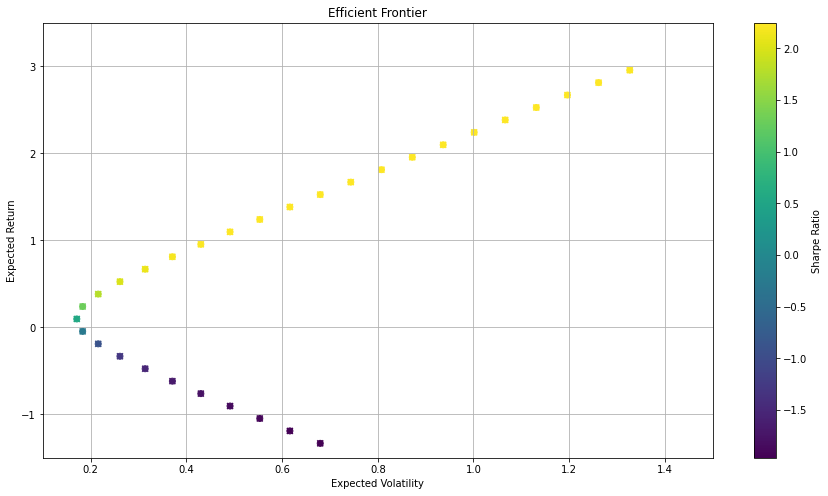

In [14]:
# Step 4:
# Plot the efficient frontier and depict the sharpe ratio in color 
plt.figure(figsize=(15, 8))
plt.scatter(std_port, ret_port, c=(ret_port - rf)/std_port, marker='o')
plt.scatter(std_port, ret_port, c=(ret_port - rf)/std_port, marker='x')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.10, 1.5)
plt.ylim(-1.5,3.5)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

This approach allows to short certain stock which results in very high returns and standard deviations. However, this results in weights which are not very applicable e.g. in the market portfolio shorting Exxon Mobile by 168%.
Another way to calculate the efficient frontier in a more applicable way is to minimize the volatility of a portfolio given a target return under constraines (weights sum up to 1, all weights 0<=w<=1)

# Mean-Efficient Frontier:

## 2. Way: minimizing volatility for a given target return under constraints

### Step 1: Generate random initial weights for each stock under two constraints:
1. Shorting a stock is not allowed. Hence, each weight is between 0 and 1
2. All weights have to add up to 1

### Step 2: Find a portfolio that maximizes the sharpe ratio
### Step 3: Find the minimum variance portfolio
### Step 4: Minimize the volatility for different chosen returns

In [15]:
# Step 1:
# receive the number of stocks
num_stocks = len(stocks)

# Generate random weights between 0 and 1 for each of the stock
weights = np.random.random(num_stocks)

# Constrain these weights to add up to 1
weights /= np.sum(weights)

weights

array([0.07659506, 0.01862776, 0.07746988, 0.04011939, 0.02387642,
       0.05685287, 0.06209488, 0.04951766, 0.02263174, 0.00926742,
       0.06923855, 0.0422494 , 0.04025568, 0.07643455, 0.07734114,
       0.03671046, 0.03228567, 0.06120707, 0.0354987 , 0.0711357 ,
       0.01683887, 0.00375113])

In [16]:
# Define a function which generates N number of random portfolios given a DataFrame of log returns
def gen_port(returns, N):
    port_rets = []
    port_sd = []
    for i in range(N):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        port_rets.append(np.sum(returns.mean() * weights) * 252)
        port_sd.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    port_rets = np.array(port_rets)
    port_sd = np.array(port_sd)
    return port_rets, port_sd

In [17]:
# Use the function to generate returns and volatilities of 5000 random portfolios
port_rets, port_sd = gen_port(ret, 5000)

Text(0.5, 1.0, 'Risk-Return combinations of 5000 Randomly Generated Portfolios')

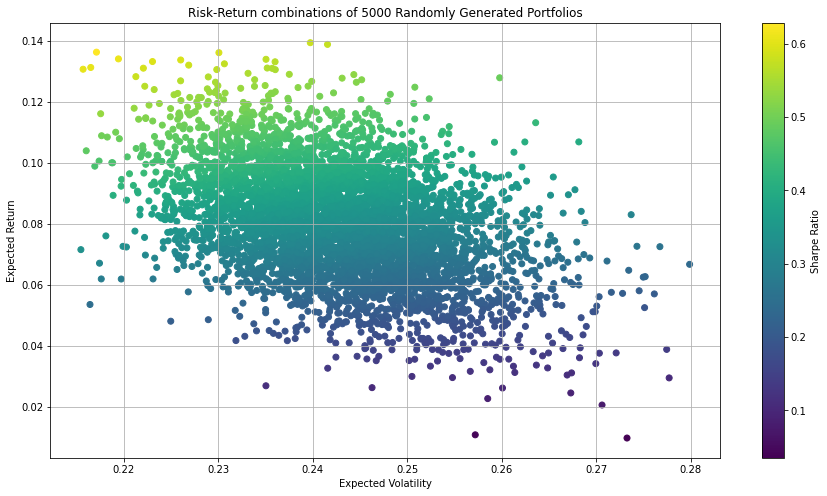

In [18]:
# Plot the 5000 randomly generated portfolio returns and volatilities. Represent the respective Sharpe ratios in colors

plt.figure(figsize=(15, 8))
plt.scatter(port_sd, port_rets, c=(port_rets - rf)/port_sd, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Risk-Return combinations of 5000 Randomly Generated Portfolios')

#### Step 2:

In [19]:
# Step 2: To find the optimal portfolios, we need to maximize the sharpe ratio
# Define a function that returns the portfolio statistics - mean return, volatility, and sharpe ratio
def port_stats(weights):
    weights = np.array(weights)
    port_ret = np.sum(ret.mean() * weights) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([port_ret, port_std, (port_ret - rf) / port_std])


# Define a function that returns the negative Sharpe ratio of a portfolio
def min_sharpe(weights):
    return -port_stats(weights)[2]

# Create the constraint that the weights have to add up to 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Set the Bounds of the weights (parameter inputs) to be within 0 and 1
bnds = tuple((0, 1) for x in range(num_stocks))

In [20]:
# Start with equally distributed weights
starting_weights = num_stocks * [1. / num_stocks,]

# Minimize the negative sharpe ratio using the scipy package
opt_sr = sco.minimize(min_sharpe, starting_weights, method='SLSQP', bounds=bnds, constraints=cons)

# Print the results
print(opt_sr)

     fun: -1.1270539030371483
     jac: array([ 1.72487454e+00,  9.98760208e-01, -1.73076987e-04,  8.05705786e-05,
        4.60345760e-01,  3.53596896e-01,  4.82197568e-01,  3.39963153e-01,
        1.69047312e+00,  7.47790515e-01,  7.95613527e-01,  3.74539480e-01,
       -3.09646130e-05,  1.62732895e+00,  3.26363459e-01,  1.31033836e+00,
        7.89427251e-01,  7.34744206e-01,  1.07884407e-04,  4.91518378e-02,
       -7.41183758e-05,  1.19844481e-01])
 message: 'Optimization terminated successfully.'
    nfev: 193
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 1.94754054e-01, 3.52202751e-01,
       2.34535946e-16, 2.53079664e-16, 8.56002744e-17, 3.13201920e-16,
       0.00000000e+00, 3.21443611e-16, 0.00000000e+00, 4.52657243e-16,
       1.05338358e-01, 8.02277411e-16, 9.29059417e-16, 0.00000000e+00,
       0.00000000e+00, 3.37122646e-16, 1.88889987e-01, 3.65277486e-16,
       1.58814850e-01, 0.00000000e+00])


In [21]:
# Create a vector with the optimal weights rounded to the 5th decimal
weights_opt_sr = opt_sr['x'].round(5)
print('optimal portfolio weights:',weights_opt_sr)

# Calculate mean return, volatility and sharpe ratio using the previous defined function
print('optimal portfolio stats:', port_stats(weights_opt_sr))

optimal portfolio weights: [0.      0.      0.19475 0.3522  0.      0.      0.      0.      0.
 0.      0.      0.      0.10534 0.      0.      0.      0.      0.
 0.18889 0.      0.15881 0.     ]
optimal portfolio stats: [0.28867861 0.25613558 1.1270539 ]


The Portfolio that maximizes the sharpe ratio only invests in a few stocks. Most of the stocks have a weight of zero.

#### Step 3:

In [22]:
# Step 3: Next, we can obtain the absolute minimum variance portfolio.
# As the name suggests, in order to obtain this portfolio, we minimise the portfolio variance.

# Define a function that returns portfolio variance (volatility or standard deviation squared)
def min_var(weights):
    return port_stats(weights)[1]**2

In [23]:
# Use the scipy package to minimize the variance
opt_var = sco.minimize(min_var, starting_weights, method='SLSQP', bounds=bnds, constraints=cons)
print(opt_var)

     fun: 0.032344962915204084
     jac: array([0.09425301, 0.07182218, 0.06469267, 0.07002205, 0.06477821,
       0.06470083, 0.06453394, 0.06475018, 0.06750388, 0.07807779,
       0.08536418, 0.07755026, 0.06471083, 0.07283081, 0.06465875,
       0.07880051, 0.07461177, 0.07043175, 0.07697313, 0.06491109,
       0.06463238, 0.06468113])
 message: 'Optimization terminated successfully.'
    nfev: 336
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([9.70841255e-18, 5.40485819e-18, 5.30092799e-03, 1.33140049e-17,
       9.37982246e-03, 5.32078879e-02, 8.08873654e-02, 8.97908099e-02,
       0.00000000e+00, 1.52655855e-18, 8.16890827e-19, 3.09934711e-18,
       1.95168903e-02, 0.00000000e+00, 6.11096539e-02, 0.00000000e+00,
       8.83244876e-18, 0.00000000e+00, 0.00000000e+00, 1.02339524e-01,
       2.10505590e-01, 3.67961529e-01])


In [24]:
# Create a vector with the optimal weights rounded to the 5th decimal
weights_opt_var = opt_var['x'].round(5)
print('optimal portfolio weights (absolute minimum variance):', weights_opt_var)

# Calculate mean return, volatility and sharpe ratio using the previous defined function
print('optimal portfolio stats (absolute minimum variance):',port_stats(weights_opt_var))

optimal portfolio weights (absolute minimum variance): [0.      0.      0.0053  0.      0.00938 0.05321 0.08089 0.08979 0.
 0.      0.      0.      0.01952 0.      0.06111 0.      0.      0.
 0.      0.10234 0.21051 0.36796]
optimal portfolio stats (absolute minimum variance): [0.11012553 0.17984885 0.61232265]


For the minimum variance portfolio, more stocks are invested in or, put differently, there are less stocks with weighst of zero than in the maximum sharpe ratio portfolio.

#### Step 4:

In [25]:
# Step 4:
# Set up two conditions, first for the target return level and second the sum of the portfolio weights is equal to 1 condition
cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)[0] - r},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The boundary condition stays the same
bnds2 = tuple((0, 1) for x in weights)

# Define a function that returns the volatility of a portfolio given a vector of weights
def port_vol(weights):
    return port_stats(weights)[1]

In [26]:
# Define a function to get the target returns and volatilities given a range of returns
def efficient_frontier(start_r, end_r, steps):
    target_rets = np.linspace(start_r, end_r, steps)
    target_sds = []
    for r in target_rets:
        cons2 = ({'type': 'eq', 'fun': lambda x: port_stats(x)[0] - r},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds2 = tuple((0, 1) for x in weights)
        res = sco.minimize(port_vol, starting_weights, method='SLSQP', bounds = bnds2, constraints=cons2)
        target_sds.append(res['fun'])
    target_sds = np.array(target_sds)
    return target_rets, target_sds

In [27]:
# Create two lists, one with the target returns and one with the volatilities based on 50 target returns in the range of 0 to 30%
target_rets, target_sds = efficient_frontier(0.0, 0.30, 50)

Text(0.5, 1.0, 'Efficient Frontier')

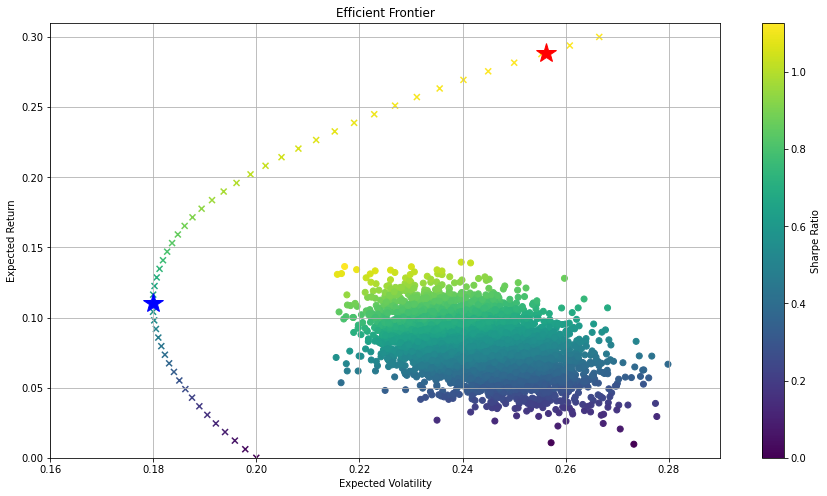

In [28]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(port_sd, port_rets, c=(port_rets - rf)/port_sd, marker='o')
plt.scatter(target_sds, target_rets, c=(target_rets - rf)/target_sds, marker='x')
plt.plot(port_stats(opt_sr['x'])[1], port_stats(opt_sr['x'])[0], 'r*', markersize=20.0)
plt.plot(port_stats(opt_var['x'])[1], port_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.16, 0.29)
plt.ylim(0.00,0.31)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

The blue star depicts the absolute minimum variance portfolio and the red star depicts the absolute maximum Sharpe ratio portfolio. Compared to the closed form solution, this approach leads to lower returns but also lower volatilities. However, the sharpe ratio is higher in the closed form solution. 

# Capital Market Line
When Investors are able to invest in and borrow at the risk free rate, they will invest in linear combinations of the risk free asset and a tangent portfolio of the efficient frontier. This line is called Captial Market Line. In a next step, this line is plotted into the efficient frontier graph

In [29]:
# Select the index of the minimum variance portfolio
min_var = np.argmin(target_sds)

# Now choose the portfolios on the efficient frontier with higher returns (and hence also higher volatilities):
# Select the volatilities of those portfolios 
ex_stds = target_sds[min_var:]

# Select the returns of those portfolios
ex_rs = target_rets[min_var:]

# Interpolate the B-spline representation of the data points
tck = sci.splrep(ex_stds, ex_rs)


# Obtain coordinates to be used for plotting the B-spline interpolation of the efficient frontier
x_lower = min(ex_stds)
x_upper = max(ex_stds)
x_range = np.linspace(x_lower, x_upper, 500)
bspline = sci.splev(x_range, tck)

Text(0.5, 1.0, 'Efficient Frontier')

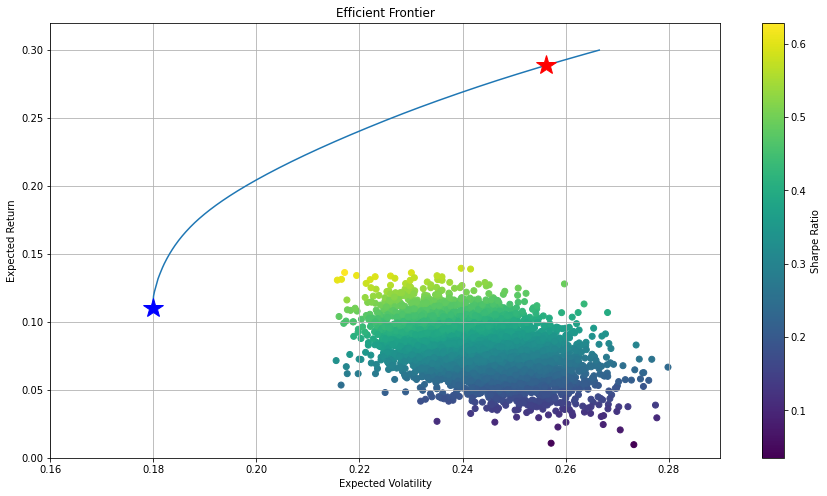

In [30]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(port_sd, port_rets, c=(port_rets - rf)/port_sd, marker='o')
plt.plot(x_range, bspline)
plt.plot(port_stats(opt_sr['x'])[1], port_stats(opt_sr['x'])[0], 'r*', markersize=20.0)
plt.plot(port_stats(opt_var['x'])[1], port_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.16, 0.29)
plt.ylim(0.00,0.32)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

In [31]:
# Define a continuously differentiable function f(x) for the efficient frontier
def f(x):
    return sci.splev(x, tck, der=0)

# Define the first derivate function of f(x)
def derivate(x):
    return sci.splev(x, tck, der=1)


def cml_conditions(p, rf=0.00):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - derivate(p[2])
    return eq1, eq2, eq3

# Solve for the parameters of the Capital Market Line
cml = sco.fsolve(cml_conditions, [0, 0.5, 0.15])

# Create input variable for CML
cx = np.linspace(0.0, 0.3)

Text(0.5, 1.0, 'Efficient Frontier')

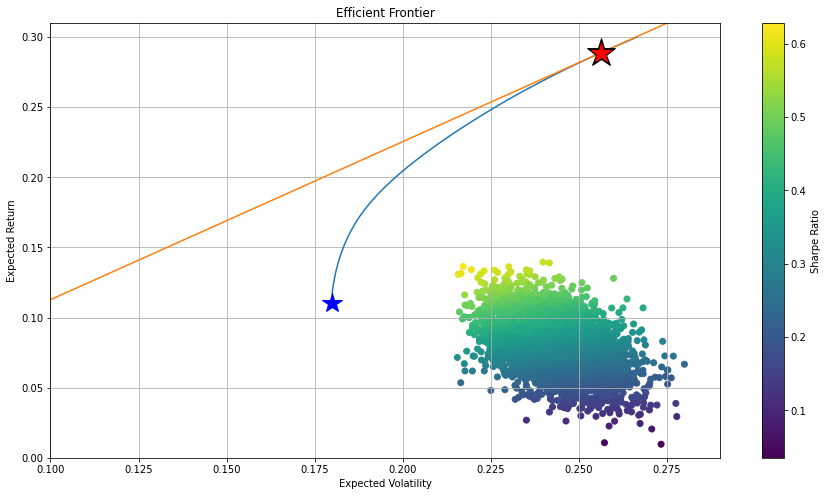

In [32]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(port_sd, port_rets, c=(port_rets - rf)/port_sd, marker='o') # Random portfolios
plt.plot(x_range, bspline, label='Efficient Frontier') # Efficient Frontier
plt.plot(cx, cml[0] + cml[1] * cx, lw=1.5, label='Capital Market Line') # Capital Market Line
plt.plot(cml[2], f(cml[2]), 'k*', markersize=30.0) # Optimal portfolio where the tangent line passes through rf
plt.plot(port_stats(opt_sr['x'])[1], port_stats(opt_sr['x'])[0], 'r*', markersize=20.0)
plt.plot(port_stats(opt_var['x'])[1], port_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.1, 0.29)
plt.ylim(0.0,0.31)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

On the Capital Market Line printed in orange, Investors can invest by splitting their investments in the market portfolio (maximum sharpe ratio portfolio) and the risk-free asset. By borrowing for the risk-free rate, investors can lever their return resulting in returns above the efficient frontier right from the market portfolio.

# Investment Performance
As a next step the performance of the minimum variance portfolio (MVP) and the maximum sharpe ratio portfolio (MSR) are compared for a given time period.
#### Step 1: Set investment amount and time horizon
#### Step 2: Initialize the portfolio
#### Step 3: Calculate the returns of the different portfolios
#### Step 4: Calculate the volatility of the different portfolios
#### Step 5: Plot the price developments of the different portfolios

In [33]:
# Step 1:
# Set the investment amount to 1,000,000 USD Dollar
invest=1e6
# Set the time horizon to 30 days
timehorizon=30

#### Step 1:

In [34]:
# Step 2:
#retrieve the stock price 30 days ago
price_30=df.iloc[-timehorizon]

# form the MVP and MSR allowing no fracions of stocks
mvp_shares=invest*weights_opt_var//(price_30)
msr_shares=invest*weights_opt_sr//(price_30)

#calculate the spare cash
mvp_cash=invest-np.sum(mvp_shares*price_30)
msr_cash=invest-np.sum(msr_shares*price_30)
print('Cash at hand for MVP',round(mvp_cash,2), 'and Cash at hand for MSR', round(msr_cash,2))

#calculate the value of each stock in the portfolio on the initial day
mvp_value=(mvp_shares*price_30)
msr_value=(msr_shares*price_30)

Cash at hand for MVP 624.68 and Cash at hand for MSR 377.87


#### Step 3:

In [35]:
# Step 3:
# Calculate the price development of the different portfolios
# first the MVP
# first create a dataframe of the values with the stock tickers as column names
mvp_value_1=mvp_value.to_frame().transpose()

# use a loop to multiple the prices with the respective returns and add them to the dataframe
for i in range(-(timehorizon-1),0):
    mvp_value_1=mvp_value_1.append(mvp_value_1.iloc[-1]*(1+ret.iloc[i]), ignore_index=True)

# set the index to the dates
mvp_value=mvp_value_1.set_index(ret.tail(timehorizon).index)


# repeat the steps for the MSR
msr_value_1=msr_value.to_frame().transpose()

for i in range(-(timehorizon-1),0):
    msr_value_1=msr_value_1.append(msr_value_1.iloc[-1]*(1+ret.iloc[i]), ignore_index=True)

msr_value=msr_value_1.set_index(ret.tail(timehorizon).index)

In [36]:
# Add up the values of all stocks to get the value of the portfolio, include the cash position
# since the riskfree rate is equal to zero, no interest is received on the cash
# first the MVP

mvp_value_total=mvp_value.sum(axis=1)+mvp_cash

# now the MSR
msr_value_total=msr_value.sum(axis=1)+msr_cash
print(mvp_value_total.tail())

Date
2020-11-23    1.034006e+06
2020-11-24    1.039282e+06
2020-11-25    1.037581e+06
2020-11-27    1.038391e+06
2020-11-30    1.041110e+06
dtype: float64


#### Step 4:

In [37]:
# To calculate the volatilities of this hoirzon, calculate the returns first and then the respective standard deviations
# MVP:
# log returns
mvp_ret=np.log(mvp_value_total/mvp_value_total.shift(1))
# Drop missing values
mvp_ret=mvp_ret.dropna()

# annualized mean returns
mvp_ret_mean=mvp_ret.mean()*252

# annualized volatility
mvp_vol=np.sqrt(mvp_ret.var()*252)

# MSR:
# log returns
msr_ret=np.log(msr_value_total/msr_value_total.shift(1))
# Drop missing values
msr_ret=msr_ret.dropna()

# annualized mean returns
msr_ret_mean=msr_ret.mean()*252

# annualized volatility
msr_vol=np.sqrt(msr_ret.var()*252)

#### Step 5:

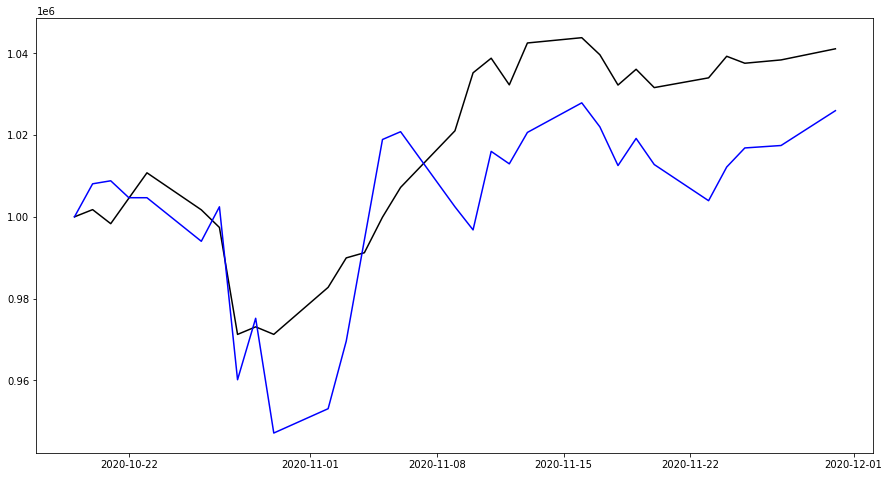

In [38]:
# Step 5:
plt.figure(figsize=(15, 8))
plt.plot(mvp_value_total,'k', markersize=30.0)
plt.plot(msr_value_total,'b', markersize=30.0)



In [39]:
# Show the performance results:
# average returns:
if mvp_ret_mean<msr_ret_mean:
    print('The annualized average return of the MVP was smaller by %d percentage points compared to the MSR'%((msr_ret_mean-mvp_ret_mean)*100))
elif mvp_ret_mean>msr_ret_mean:
    print('The annualized average return of the MVP was larger by %d percentage points compared to the MSR'%((mvp_ret_mean-msr_ret_mean)*100))
else:
    print('The annualized average return of the MVP and the MSR was %d percent'%((mvp_ret_mean)*100))

# volatility:
if mvp_vol<msr_vol:
    print('The annualized volatility of the MVP was indeed smaller compared to the MSR by %d percentage points'%((msr_vol-mvp_vol)*100))
elif mvp_ret_mean>msr_ret_mean:
    print('The annualized volatility of the MVP was acutally larger compared to the MSR by %d percentage points'%((mvp_vol-msr_vol)*100))
else:
    print('The annualized volatility of the MVP and the MSR was %d percent'%((mvp_vol)*100))

The annualized average return of the MVP was larger by 12 percentage points compared to the MSR
The annualized volatility of the MVP was indeed smaller compared to the MSR by 10 percentage points


In [40]:
# How much money would an investor have made?
# MVP:
# return in percent p.a.
mvp_return=np.log(mvp_value_total.iloc[-1]/mvp_value_total.iloc[0])*(252/timehorizon)
# return in money-terms
mvp_return_money=mvp_value_total.iloc[-1]-mvp_value_total.iloc[0]

# MSR:
# return in percent p.a.
msr_return=np.log(msr_value_total.iloc[-1]/msr_value_total.iloc[0])*(252/timehorizon)
# return in money-terms
msr_return_money=msr_value_total.iloc[-1]-msr_value_total.iloc[0]

print('Investing in the MVP would have let to a profit of %d USD representing a return of' %mvp_return_money, round(mvp_return*100,2),'percent p.a.')
print('Investing in the MSR would have let to a profit of %d USD representing a return of' %msr_return_money, round(msr_return*100,2), 'percent p.a.')

Investing in the MVP would have let to a profit of 41110 USD representing a return of 33.84 percent p.a.
Investing in the MSR would have let to a profit of 25972 USD representing a return of 21.54 percent p.a.


The main caveat of the performance analysis is that it uses in-sample data. In other words, the portfolios are constructed based on data that includes the returns which are used for the performance analysis. Hence, it is likely that the MVP has indeed a lower variance and a lower return compared to the MSR. In addition, the underlying Finance Theories assume expected Returns while this analysis uses historical data given its availability.